# Table of Contents
 <p><div class="lev1 toc-item"><a href="#reading-and-preparing-data" data-toc-modified-id="reading-and-preparing-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>reading and preparing data</a></div><div class="lev1 toc-item"><a href="#Trajector-Clustering-on-Dimension-reduction" data-toc-modified-id="Trajector-Clustering-on-Dimension-reduction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Trajector Clustering on Dimension reduction</a></div><div class="lev2 toc-item"><a href="#using-4-clusters-on-PC1." data-toc-modified-id="using-4-clusters-on-PC1.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>using 4 clusters on PC1.</a></div><div class="lev1 toc-item"><a href="#Trajectory-Clustering-by-Weight" data-toc-modified-id="Trajectory-Clustering-by-Weight-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Trajectory Clustering by Weight</a></div>

# reading and preparing data

In [117]:
#library(ggbiplot)
library(tidyverse, quiet=T)
library(traj)
library(caret, quiet=T)

In [118]:
dat0 <- read.csv("../training_ultrasound.csv")

# Use Hadlok equation to estimate fetal weight from the 4 key ultrasound measurements
dat.raw = dat0 %>%
    mutate(
        LOG10.FWT.GM = 1.3596 + 0.0064*HCIRCM + 0.0424*ABCIRCM + 0.174*FEMURCM + 0.00061*BPDCM*ABCIRCM - 0.00386*ABCIRCM*FEMURCM,
        WTKG.estimate = ifelse(AGEDAYS<1 ,(10^LOG10.FWT.GM)/1000 ,WTKG) ,
        Study = paste('Study', STUDYID)
        )
dat.raw %>% glimpse
# clean data, remove samples with only one observation and after-birth
dat = dat.raw %>% group_by(SUBJID) %>%
    mutate(tot.measurements = n()) %>%
    filter(tot.measurements >1) %>%
    filter(AGEDAYS<0)


dat.train.raw = dat %>% ungroup %>%
    select(GAGEDAYS, SUBJID, ABCIRCM, HCIRCM, BPDCM, FEMURCM, WTKG.estimate) %>%
    filter(complete.cases(.)) %>% group_by(SUBJID) %>%
    mutate(measurementId = row_number(), tot_measurements=n()) %>%
    filter(measurementId < 7) %>%
    filter(tot_measurements >1) %>% 
    ungroup %>%
     filter(GAGEDAYS > 100, GAGEDAYS <310)

dat.train = dat.train.raw %>% dplyr::select(-WTKG.estimate)
dat.train.raw %>% head

Observations: 17,370
Variables: 37
$ STUDYID       <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ SUBJID        <int> 1002, 1002, 1002, 1003, 1003, 1003, 1003, 1003, 1003,...
$ SEXN          <int> 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ SEX           <fctr> Female, Female, Female, Male, Male, Male, Male, Male...
$ GAGEBRTH      <int> 276, 276, 276, 280, 280, 280, 280, 280, 280, 280, 280...
$ BIRTHWT       <int> 3540, 3540, 3540, 3100, 3100, 3100, 3100, 3100, 3100,...
$ BIRTHLEN      <dbl> 50.3, 50.3, 50.3, 50.3, 50.3, 50.3, 50.3, 50.3, 50.3,...
$ BIRTHHC       <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N...
$ DELIVERY      <fctr> Category 2.0, Category 2.0, Category 2.0, Category 2...
$ PARITY        <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ GRAVIDA       <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ GAGEDAYS      <int> 255, 277, 669, 223, 224, 263, 266, 281, 321, 463, 645...
$ AGEDAYS       <

GAGEDAYS,SUBJID,ABCIRCM,HCIRCM,BPDCM,FEMURCM,WTKG.estimate,measurementId,tot_measurements
223,1003,25.6,29.2,8.2,6.3,1.7124993,1,4
224,1003,25.6,29.2,8.2,6.3,1.7124993,2,4
263,1003,30.2,31.0,9.1,7.2,2.6278574,3,4
266,1003,30.2,31.0,9.1,7.2,2.6278574,4,4
169,1005,18.7,21.9,5.9,4.1,0.5989562,1,3
222,1005,25.7,27.9,7.9,5.5,1.4557182,2,3


# Trajector Clustering on Dimension reduction

We use PCA to reduce the four physical variables to one single dimension

In [119]:
#dat.train %>% head

dat.prcomp = dat.train  %>%
    select(-GAGEDAYS, -SUBJID, -measurementId, -tot_measurements) %>% 
    filter(complete.cases(.)) %>% 
    mutate_each(funs(as.numeric(.))) %>%
    prcomp(., center=T, scale.=T)

dat.train  %>%
    select(-GAGEDAYS, -SUBJID, -measurementId, -tot_measurements) %>% 
    filter(complete.cases(.)) %>% 
    head
dat.prcomp$x %>% head

dat.train %>% nrow

ABCIRCM,HCIRCM,BPDCM,FEMURCM
25.6,29.2,8.2,6.3
25.6,29.2,8.2,6.3
30.2,31.0,9.1,7.2
30.2,31.0,9.1,7.2
18.7,21.9,5.9,4.1
25.7,27.9,7.9,5.5


PC1,PC2,PC3,PC4
-0.7259952,0.19000650,-0.2912082,0.01129281
-0.7259952,0.19000650,-0.2912082,0.01129281
-1.9086354,-0.02391508,-0.2858182,-0.20697391
-1.9086354,-0.02391508,-0.2858182,-0.20697391
2.1286479,0.06515534,0.1024382,0.08093121
-0.2038839,0.20896379,0.1604442,-0.01146474


[1] 7164

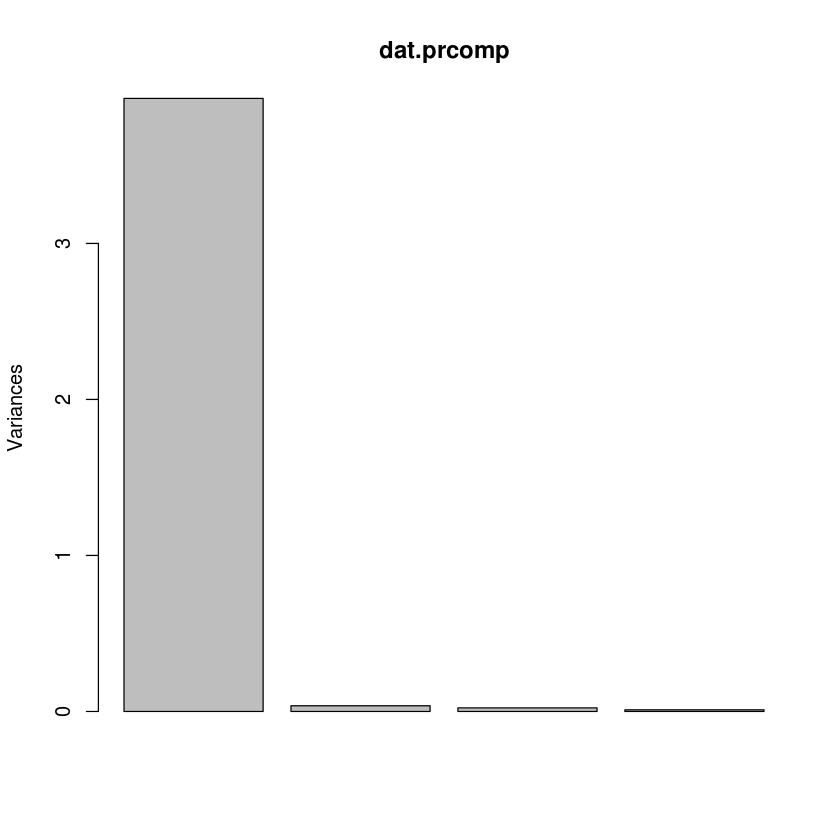

In [120]:
plot(dat.prcomp)

In [145]:
PC = dat.prcomp$x %>% tbl_df %>% select(PC1, PC2) 

dat.train$PC1 = -1 * PC$PC1
dat.train$PC2 = -1 * PC$PC2
dat.train %>% head



GAGEDAYS,SUBJID,ABCIRCM,HCIRCM,BPDCM,FEMURCM,measurementId,tot_measurements,PC1,PC2
223,1003,25.6,29.2,8.2,6.3,1,4,0.7259952,-0.19000650
224,1003,25.6,29.2,8.2,6.3,2,4,0.7259952,-0.19000650
263,1003,30.2,31.0,9.1,7.2,3,4,1.9086354,0.02391508
266,1003,30.2,31.0,9.1,7.2,4,4,1.9086354,0.02391508
169,1005,18.7,21.9,5.9,4.1,1,3,-2.1286479,-0.06515534
222,1005,25.7,27.9,7.9,5.5,2,3,0.2038839,-0.20896379


In [122]:
dat.times = dat.train %>% 
    select(SUBJID, measurementId, GAGEDAYS) %>% 
    spread(measurementId, GAGEDAYS) %>% 
#    filter(complete.cases(.)) %>% 
    as.matrix
dat.values = dat.train %>% 
    select(SUBJID, measurementId, PC1) %>%  
    spread(measurementId, PC1) %>% 
#    filter(complete.cases(.)) %>% 
    as.matrix

In [123]:
dat.times %>% head
dat.values %>% head


,SUBJID,1,2,3,4,5,6
1,1003,223,224,263,266,NA,NA
2,1005,169,222,264,NA,NA,NA
3,1006,222,266,NA,NA,NA,NA
4,1009,168,231,NA,NA,NA,NA
5,1011,168,219,261,NA,NA,NA
6,1012,168,169,231,232,259,260


,SUBJID,1,2,3,4,5,6
1,1003,0.7259952,0.7259952,1.908635,1.908635,NA,NA
2,1005,-2.1286479,0.2038839,1.664705,NA,NA,NA
3,1006,0.7414450,1.9884762,NA,NA,NA,NA
4,1009,-2.5661299,0.6405581,NA,NA,NA,NA
5,1011,-2.4107879,-0.1732034,1.323432,NA,NA,NA
6,1012,-2.2493502,-2.2493502,1.039961,1.039961,2.286775,2.286775


In [124]:
library(traj)

In [125]:
s1.pc1 = step1measures(dat.values, dat.times, ID=T)

[1] "Correlation of m1 and m5 : 1"
[1] "Correlation of m11 and m15 : 1"


In [126]:
s2.pc1 = step2factors(s1.pc1)

[1] "m5 is removed because it is perfectly correlated with m1"  
[2] "m15 is removed because it is perfectly correlated with m11"
[1] "Computing reduced correlation e-values..."


In [127]:
s3.pc1 = step3clusters(s2.pc1,4 )
s3.pc1$clusters %>% count(cluster)


cluster,n
1,1
2,12
3,5
4,578


## using 4 clusters on PC1. 

Cluster 4 has a drop between days 150-200

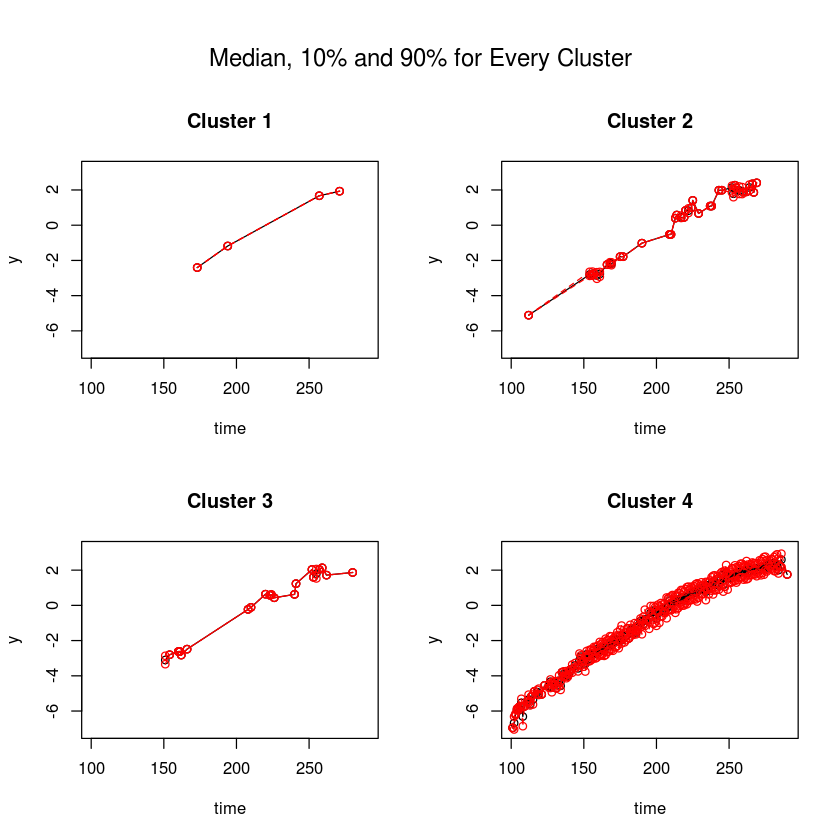

In [128]:
plotMedTraj(s3.pc1)

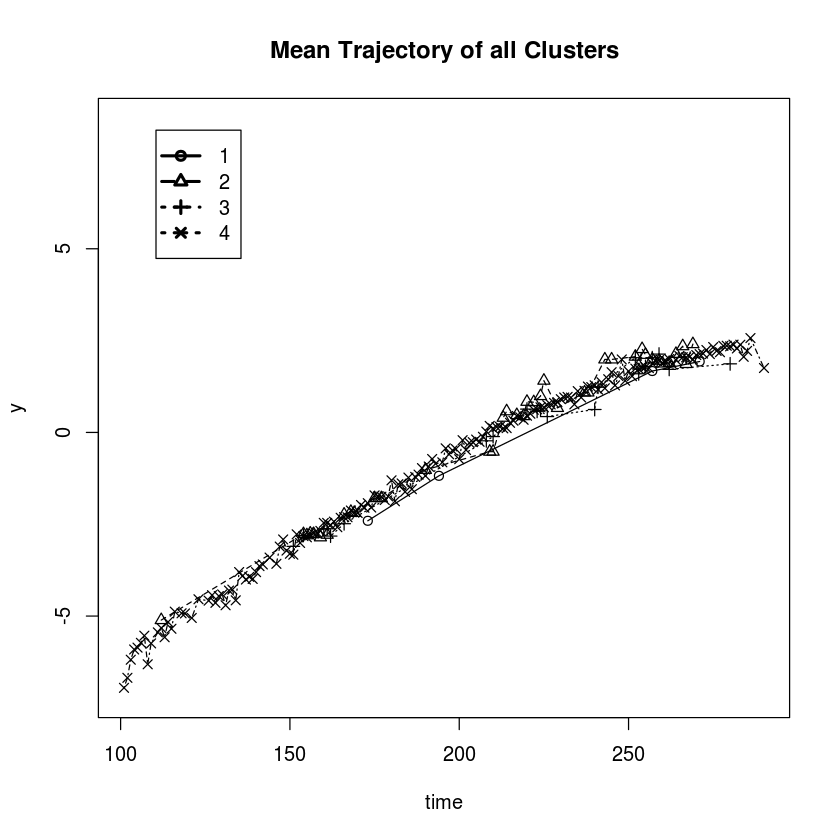

In [129]:
plotCombTraj(s3.pc1)

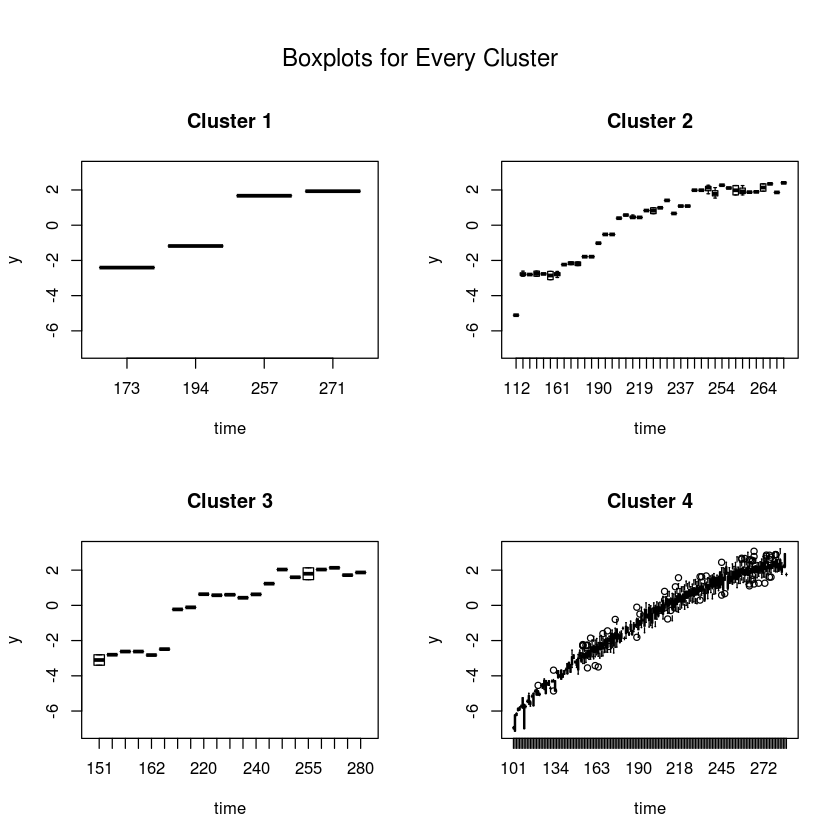

In [130]:
plotBoxplotTraj(s3.pc1)

In [151]:
s3.pc1$clusters %>% head
dat.clusters = dat %>% left_join(s3.pc1$clusters %>% rename(SUBJID=ID), by="SUBJID") %>% filter(cluster %in% c(2,4))


ID,cluster
1003,4
1012,4
1015,4
1018,4
1026,4
1027,4


In [155]:
dat.glm = dat.clusters %>% glm(I(cluster==2)~SEX+STUDYID+GRAVIDA, data=., family="binomial")
dat.glm %>% summary


Call:
glm(formula = I(cluster == 2) ~ SEX + STUDYID + GRAVIDA, family = "binomial", 
    data = .)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5554  -0.2079  -0.2079  -0.1502   2.9970  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   9.2496   729.0359   0.013 0.989877    
SEXMale       0.6564     0.2685   2.444 0.014517 *  
STUDYID     -14.2373   729.0359  -0.020 0.984419    
GRAVIDA       0.5080     0.1330   3.820 0.000134 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 626.17  on 2986  degrees of freedom
Residual deviance: 605.81  on 2983  degrees of freedom
  (6 observations deleted due to missingness)
AIC: 613.81

Number of Fisher Scoring iterations: 16


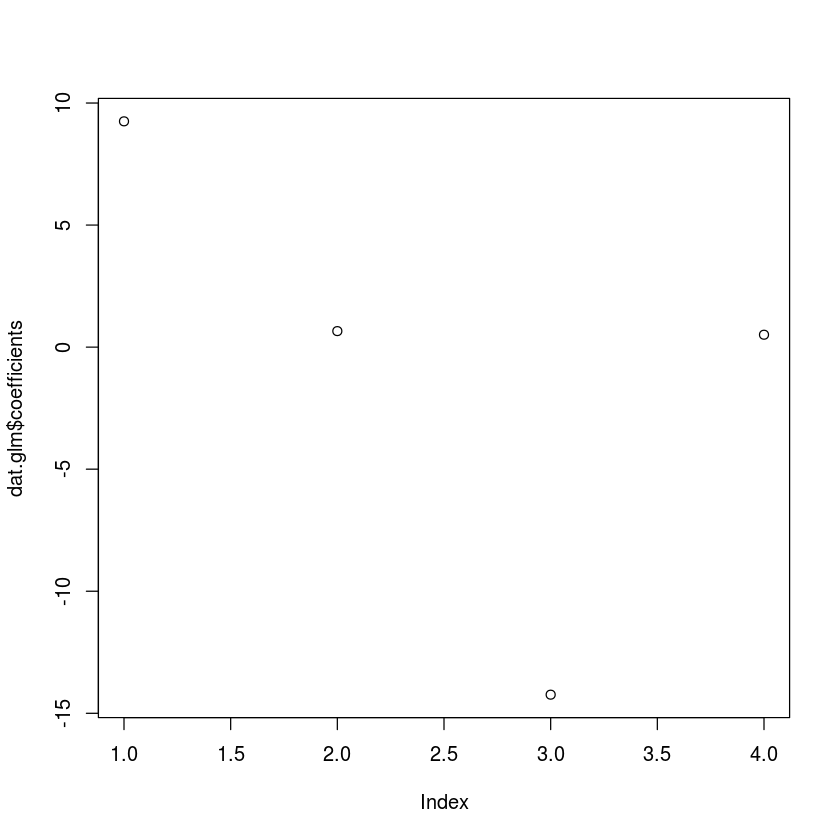

In [157]:
plot(dat.glm$coefficients)

# Trajectory Clustering by Weight


In [137]:
dat.train.raw %>% head


GAGEDAYS,SUBJID,ABCIRCM,HCIRCM,BPDCM,FEMURCM,WTKG.estimate,measurementId,tot_measurements
223,1003,25.6,29.2,8.2,6.3,1.7124993,1,4
224,1003,25.6,29.2,8.2,6.3,1.7124993,2,4
263,1003,30.2,31.0,9.1,7.2,2.6278574,3,4
266,1003,30.2,31.0,9.1,7.2,2.6278574,4,4
169,1005,18.7,21.9,5.9,4.1,0.5989562,1,3
222,1005,25.7,27.9,7.9,5.5,1.4557182,2,3


In [138]:
dat.times = dat.train.raw %>% 
    select(SUBJID, measurementId, GAGEDAYS) %>% 
    spread(measurementId, GAGEDAYS) %>% 
#    filter(complete.cases(.)) %>% 
    as.matrix
dat.values = dat.train.raw %>% 
    select(SUBJID, measurementId, WTKG.estimate) %>%  
    spread(measurementId, WTKG.estimate) %>% 
#    filter(complete.cases(.)) %>% 
    as.matrix

dat.times %>% head
dat.values %>% head

,SUBJID,1,2,3,4,5,6
1,1003,223,224,263,266,NA,NA
2,1005,169,222,264,NA,NA,NA
3,1006,222,266,NA,NA,NA,NA
4,1009,168,231,NA,NA,NA,NA
5,1011,168,219,261,NA,NA,NA
6,1012,168,169,231,232,259,260


,SUBJID,1,2,3,4,5,6
1,1003,1.7124993,1.7124993,2.627857,2.627857,NA,NA
2,1005,0.5989562,1.4557182,2.460492,NA,NA,NA
3,1006,1.7424318,2.6286793,NA,NA,NA,NA
4,1009,0.5061012,1.7751113,NA,NA,NA,NA
5,1011,0.5823398,1.2789009,2.225963,NA,NA,NA
6,1012,0.6115616,0.6115616,1.987976,1.987976,3.034302,3.034302


In [139]:
s1 = step1measures(dat.values, dat.times, ID=T)

[1] "Correlation of m1 and m5 : 0.999"
[1] "Correlation of m11 and m15 : 1"


In [140]:
s2 = step2factors(s1)

[1] "m5 is removed because it is perfectly correlated with m1"  
[2] "m15 is removed because it is perfectly correlated with m11"
[1] "Computing reduced correlation e-values..."


cluster,n
1,31
2,126
3,90
4,35
5,6
6,34
7,77
8,10
9,60
10,55


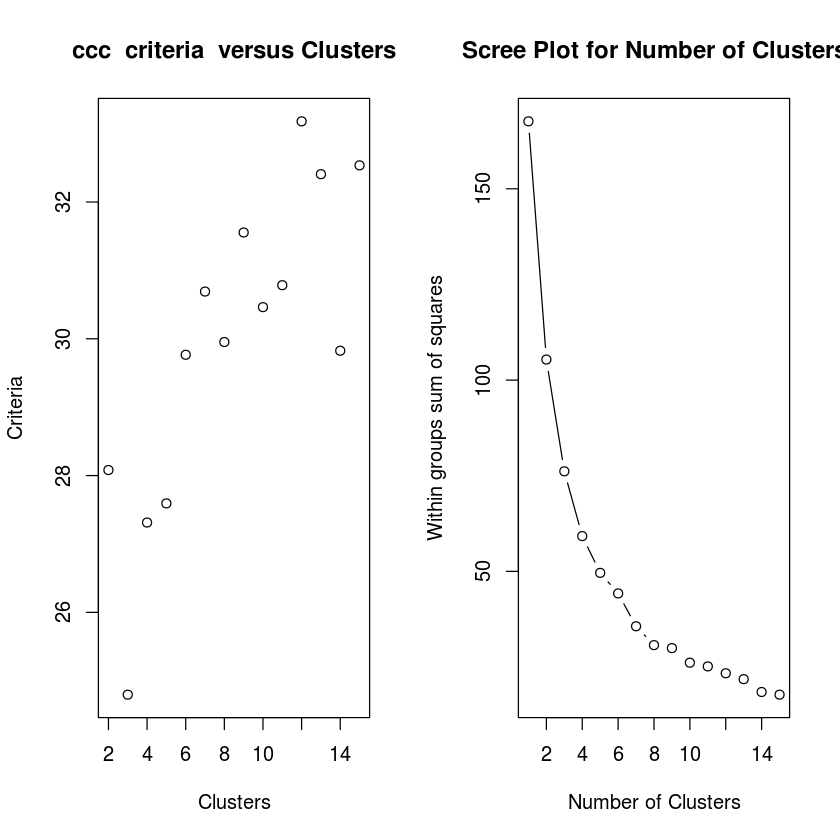

In [141]:
s3 = step3clusters(s2)
s3$clusters %>% count(cluster)

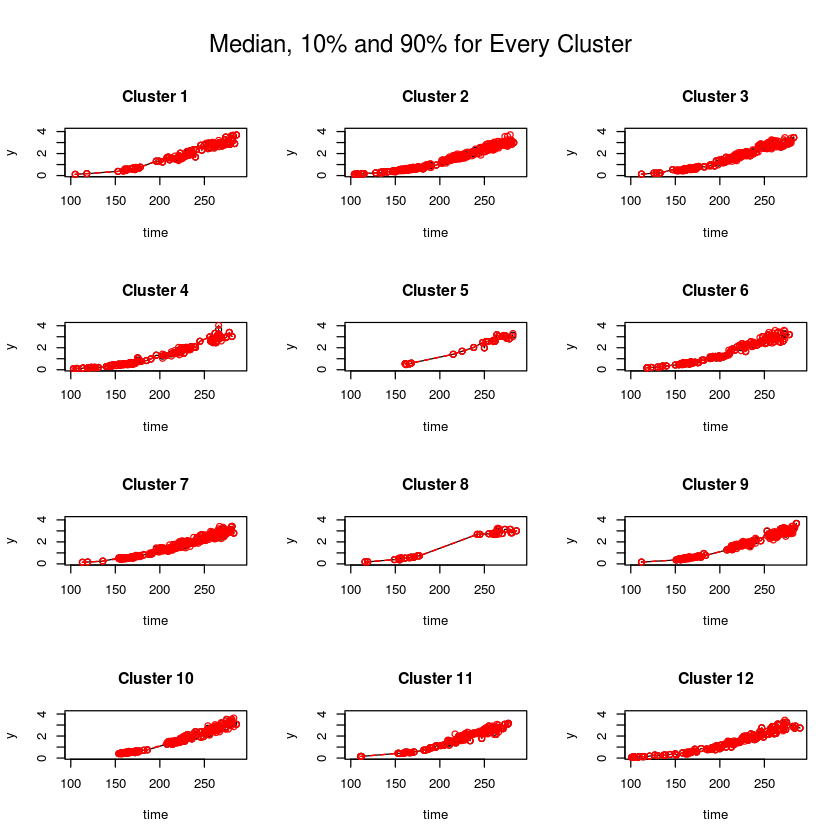

In [142]:
plotMedTraj(s3)

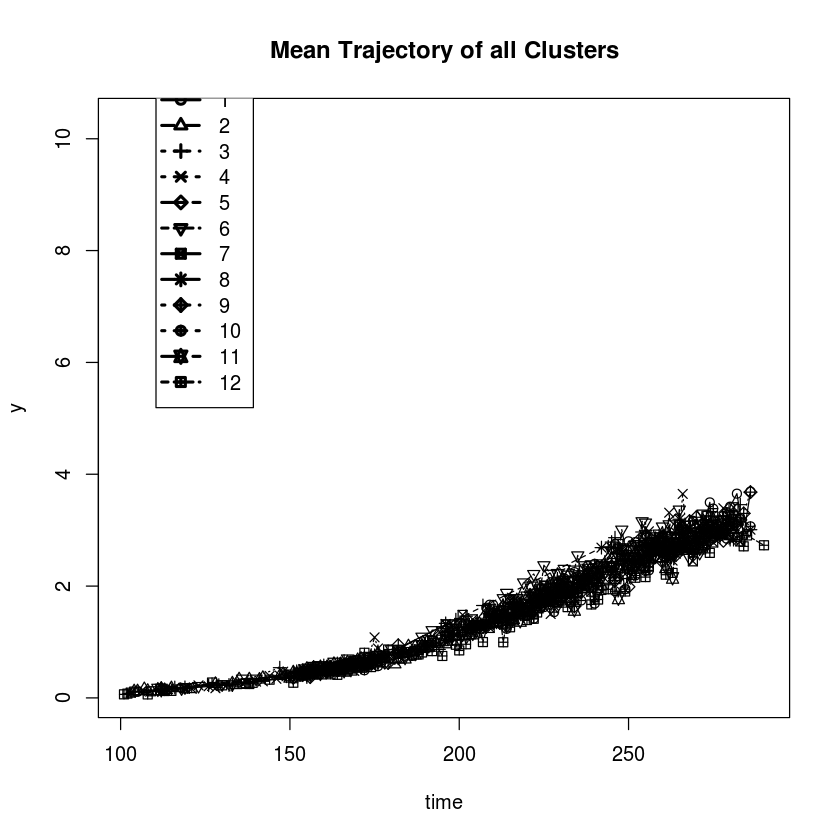

In [143]:
plotCombTraj(s3)

cluster,n
1,272
2,324


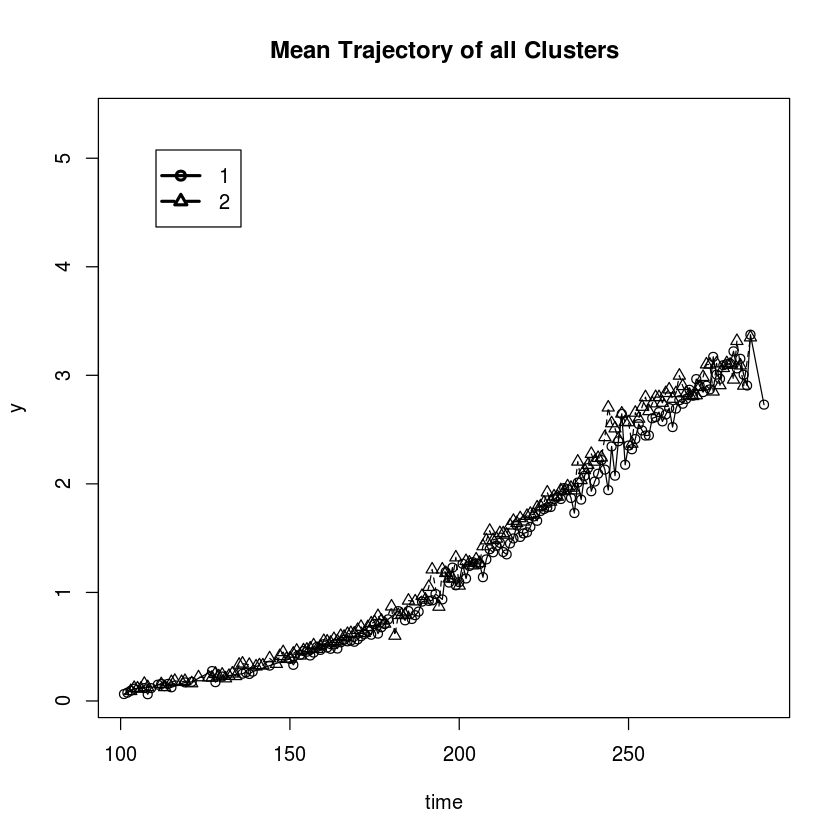

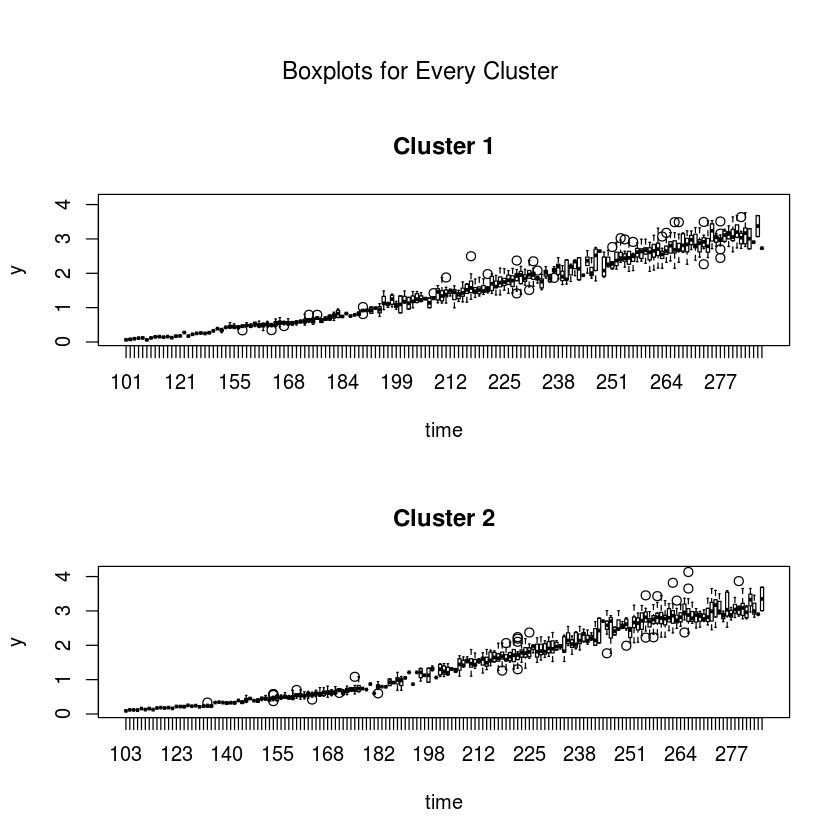

In [144]:
s3.2c = step3clusters(s2, 2)
s3.2c$clusters %>% count(cluster)
plotCombTraj(s3.2c)
plotBoxplotTraj(s3.2c)

In [159]:
dat.clusters.byweight = dat %>% left_join(
    s3.2c$clusters %>% rename(SUBJID=ID), by="SUBJID")

In [162]:
dat.clusters.byweight %>% head
dat.clusters.byweight %>% glm(cluster~SEX+GRAVIDA+STUDYID, family="binomial") %>% summary 

STUDYID,SUBJID,SEXN,SEX,GAGEBRTH,BIRTHWT,BIRTHLEN,BIRTHHC,DELIVERY,PARITY,⋯,BLEN_Z,BWT_Z,BWT_40,BLEN_40,BHC_40,LOG10.FWT.GM,WTKG.estimate,Study,tot.measurements,cluster
1,1002,2,Female,276,3540,50.3,NA,Category 2.0,1,⋯,0.8916001,0.8604704,3.614882,50.61003,NA,3.486183,3.0632504,Study 1,3,NA
1,1003,1,Male,280,3100,50.3,NA,Category 2.0,1,⋯,0.2352980,-0.7255638,3.100000,50.30000,NA,3.233630,1.7124993,Study 1,9,1
1,1003,1,Male,280,3100,50.3,NA,Category 2.0,1,⋯,0.2352980,-0.7255638,3.100000,50.30000,NA,3.233630,1.7124993,Study 1,9,1
1,1003,1,Male,280,3100,50.3,NA,Category 2.0,1,⋯,0.2352980,-0.7255638,3.100000,50.30000,NA,3.419602,2.6278574,Study 1,9,1
1,1003,1,Male,280,3100,50.3,NA,Category 2.0,1,⋯,0.2352980,-0.7255638,3.100000,50.30000,NA,3.419602,2.6278574,Study 1,9,1
1,1005,1,Male,269,2750,49.3,NA,Category 2.0,1,⋯,0.2390059,-1.0127406,2.988224,50.30595,NA,2.777395,0.5989562,Study 1,5,NA


ERROR: Error in as.data.frame.default(data): cannot coerce class ""formula"" to a data.frame
